<h4>Install prophet + plotly for interactive plotting (interactive plots are laggy)

In [1]:
!pip install prophet

In [3]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from sklearn.metrics import mean_absolute_percentage_error

f2021 = "../IT-NO_2021_hourly.csv"
f2022 = "../IT-NO_2022_hourly.csv"
f2023 = "../IT-NO_2023_hourly.csv"

dataset1 = pd.read_csv(f2021)
dataset2 = pd.read_csv(f2022)
dataset3 = pd.read_csv(f2023)

Some useful functions to plot and print graphs:

                     LCA+direct
timestamp                      
2021-01-01 00:00:00      693.03
2021-01-01 01:00:00      691.21
2021-01-01 02:00:00      672.90
2021-01-01 03:00:00      675.92
2021-01-01 04:00:00      702.72


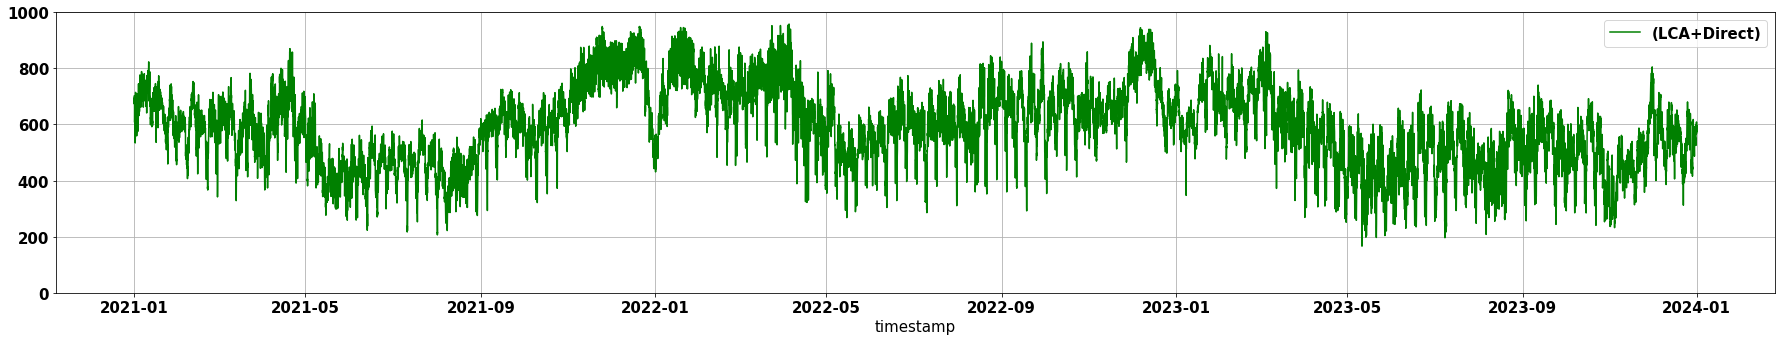

In [160]:
# Data concatenation of carbon intensity:
dataset_CI = pd.concat([dataset1, dataset2, dataset3], axis=0)
dataset_CI['Datetime (UTC)'] = pd.to_datetime(dataset_CI['Datetime (UTC)'])
dataset_CI.rename(columns={'Datetime (UTC)': 'timestamp'}, inplace=True) # Column renaming
dataset_CI.set_index('timestamp', inplace=True)
dataset_CI.drop(columns=['Country', 'Zone Name', 'Zone Id', 'Data Source', 'Data Estimated', 'Data Estimation Method', 'Low Carbon Percentage', 'Renewable Percentage'], inplace=True)
dataset_CI['LCA+direct'] = dataset_CI['Carbon Intensity gCO₂eq/kWh (LCA)'] + dataset_CI['Carbon Intensity gCO₂eq/kWh (direct)']
dataset_CI.drop(columns=['Carbon Intensity gCO₂eq/kWh (direct)', 'Carbon Intensity gCO₂eq/kWh (LCA)'], inplace=True)
print(dataset_CI.head())

# Plotting and comparison od the different CI values
x = dataset_CI.index
y = dataset_CI['LCA+direct']

# Create subplots with shared X-axis
fig, ax1 = plt.subplots(1, 1, figsize=(25, 5), sharex=True)

# Plot data on each subplot
ax1.grid(True)
ax1.plot(x, y, 'g', label='(LCA+Direct)')
ax1.set_ylim(0, 1000)
ax1.set_xlabel('timestamp')

# Add legends
ax1.legend()
plt.rc("font", weight="bold", size=15)
plt.tight_layout()
# Show the plot
plt.show()

Testing prophet on LCA+direct datapoints. documentation: https://facebook.github.io/prophet/docs/quick_start.html#python-api
 

Preparing the dataframe as required by the prophet documentation:

In [161]:
dataset_CI_fix = dataset_CI.reset_index()
dataset_CI_fix.rename(columns={'timestamp':'ds', 'LCA+direct':'y' }, inplace=True)
dataset_CI_fix.tail()

,ds,y
26275,2023-12-31 19:00:00,594.23
26276,2023-12-31 20:00:00,608.81
26277,2023-12-31 21:00:00,574.62
26278,2023-12-31 22:00:00,597.98
26279,2023-12-31 23:00:00,570.99


### Training using the different time periods & length + parameters tuning:


In [ ]:
dataset_30m = dataset_CI_fix[(dataset_CI_fix['ds'] < '2023-07')] # 2.5 years of data = 30 months
dataset_28m = dataset_30m[(dataset_30m['ds'] > '2021-03')]
dataset_26m = dataset_28m[(dataset_28m['ds'] > '2021-05')]
dataset_24m = dataset_26m[(dataset_26m['ds'] > '2021-07')]
dataset_22m = dataset_24m[(dataset_24m['ds'] > '2021-09')]
dataset_20m = dataset_22m[(dataset_22m['ds'] > '2021-11')]
dataset_18m = dataset_20m[(dataset_20m['ds'] > '2022-01')]
dataset_16m = dataset_18m[(dataset_18m['ds'] > '2022-03')]
dataset_14m = dataset_16m[(dataset_16m['ds'] > '2022-05')]
dataset_12m = dataset_14m[(dataset_14m['ds'] > '2022-07')] 
dataset_10m = dataset_12m[(dataset_12m['ds'] > '2022-09')] 

dataset_30m.name = "30 months"
dataset_28m.name = "28 months"
dataset_26m.name = "26 months" 
dataset_24m.name = "24 months"
dataset_22m.name = "22 months"
dataset_20m.name = "20 months"
dataset_18m.name = "18 months"
dataset_16m.name = "16 months"
dataset_14m.name = "14 months"
dataset_12m.name = "12 months"
dataset_10m.name = "10 months"

According to prophet documentation, https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning 
Parameters that can be tuned:

    changepoint_prior_scale: This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. As described in this documentation, if it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality. The default of 0.05 works for many time series, but this could be tuned; a range of [0.001, 0.5] would likely be about right. Parameters like this (regularization penalties; this is effectively a lasso penalty) are often tuned on a log scale.

    seasonality_prior_scale: This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is 10., which applies basically no regularization. That is because we very rarely see overfitting here (there’s inherent regularization with the fact that it is being modeled with a truncated Fourier series, so it’s essentially low-pass filtered). A reasonable range for tuning it would probably be [0.01, 10]; when set to 0.01 you should find that the magnitude of seasonality is forced to be very small. This likely also makes sense on a log scale, since it is effectively an L2 penalty like in ridge regression.

Hence, <b>using them to tune the model and finding better performance, along with using different training length and prediction length to find the best performing parameters</b>

In [106]:
datasets = [dataset_30m, dataset_28m, dataset_26m, dataset_24m, dataset_22m, dataset_20m, dataset_18m, dataset_16m, dataset_14m, dataset_12m]

errordf = pd.DataFrame(columns=['1w', '2w', '4w', '1m', '2m', '6m']) # recording all error % value here to later find the best parameters

# paramteter grid, accrding to the documaentation:
param_grid = {  
    'yearly_seasonality' : [True], 
    'weekly_seasonality' : [True], 
    'daily_seasonality' : [True],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

for dataset in datasets:
     for params in all_params: 
          m = Prophet(**params)
          m.fit(dataset)
          future = m.make_future_dataframe(periods=184) # Half a year of prediction
          forecast = m.predict(future)

          real_val = dataset_CI_fix[(dataset_CI_fix['ds'] > '2023-07')]
          real_val = real_val[(real_val['ds'].dt.hour == 23)]
          real_val = real_val.reset_index()

          pred_val = forecast[(forecast['ds'] > '2023-07')]
          pred_val = pred_val['yhat'].reset_index()

          dataset_zoom = pd.concat([real_val, pred_val], axis = 1)
          dataset_zoom.drop(columns=['index'], inplace = True)
          dataset_zoom.columns = ['Timestamp', 'Real Values', 'Prediction']
          dataset_zoom = dataset_zoom.set_index('Timestamp')
          dataset_zoom

          dataset_zoom['percerr_graph'] = (abs(dataset_zoom['Prediction']-dataset_zoom['Real Values'])/dataset_zoom['Real Values'])*100
          errordf.loc[f"{dataset.name} + {params}"] = [100*mean_absolute_percentage_error(dataset_zoom[0:7]['Real Values'], dataset_zoom[0:7]['Prediction']), 100*mean_absolute_percentage_error(dataset_zoom[0:14]['Real Values'], dataset_zoom[0:14]['Prediction']), 100*mean_absolute_percentage_error(dataset_zoom[0:21]['Real Values'], dataset_zoom[0:21]['Prediction']), 100*mean_absolute_percentage_error(dataset_zoom[0:30]['Real Values'], dataset_zoom[0:30]['Prediction']), 100*mean_absolute_percentage_error(dataset_zoom[0:60]['Real Values'], dataset_zoom[0:60]['Prediction']), 100*mean_absolute_percentage_error(dataset_zoom['Real Values'], dataset_zoom['Prediction'])] 

          del(real_val)
          del(pred_val)
          del(dataset_zoom)

          # # ERROR print: uncomment to print:
          # print(f"\nDATASET: {dataset.name}; Error calculation:\
          #      \n1 WEEK:\
          #      %Mean.Abs.Perc.Err: {100*mean_absolute_percentage_error(dataset_zoom[0:7]['Real Values'], dataset_zoom[0:7]['Prediction']):.2f}                \
          #      \n2 WEEKS:\
          #      %Mean.Abs.Perc.Err: {100*mean_absolute_percentage_error(dataset_zoom[0:14]['Real Values'], dataset_zoom[0:14]['Prediction']):.2f}                    \
          #      \n1 MONTH:\
          #      %Mean.Abs.Perc.Err: {100*mean_absolute_percentage_error(dataset_zoom[0:30]['Real Values'], dataset_zoom[0:30]['Prediction']):.2f}                         \
          #      \n2 MONTHS:\
          #      %Mean.Abs.Perc.Err: {100*mean_absolute_percentage_error(dataset_zoom[0:60]['Real Values'], dataset_zoom[0:60]['Prediction']):.2f}                   \
          #      \n6 MONTHS:\
          #      %Mean.Abs.Perc.Err: {100*mean_absolute_percentage_error(dataset_zoom['Real Values'], dataset_zoom['Prediction']):.2f}")


errordf

16:01:05 - cmdstanpy - INFO - Chain [1] start processing
16:01:08 - cmdstanpy - INFO - Chain [1] done processing
16:01:14 - cmdstanpy - INFO - Chain [1] start processing
16:01:17 - cmdstanpy - INFO - Chain [1] done processing
16:01:24 - cmdstanpy - INFO - Chain [1] start processing
16:01:27 - cmdstanpy - INFO - Chain [1] done processing
16:01:34 - cmdstanpy - INFO - Chain [1] start processing
16:01:37 - cmdstanpy - INFO - Chain [1] done processing
16:01:43 - cmdstanpy - INFO - Chain [1] start processing
16:01:52 - cmdstanpy - INFO - Chain [1] done processing
16:01:59 - cmdstanpy - INFO - Chain [1] start processing
16:02:07 - cmdstanpy - INFO - Chain [1] done processing
16:02:13 - cmdstanpy - INFO - Chain [1] start processing
16:02:27 - cmdstanpy - INFO - Chain [1] done processing
16:02:36 - cmdstanpy - INFO - Chain [1] start processing
16:02:46 - cmdstanpy - INFO - Chain [1] done processing
16:02:52 - cmdstanpy - INFO - Chain [1] start processing
16:03:13 - cmdstanpy - INFO - Chain [1]

,1w,2w,4w,1m,2m,6m
"30 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}",13.630485,13.280979,13.799278,12.413116,12.352720,20.469702
"30 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}",13.530206,13.325199,13.882502,12.535719,12.518239,20.476328
"30 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}",13.515818,13.331933,13.895619,12.554807,12.542607,20.451458
"30 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}",13.563151,13.297227,13.834410,12.468842,12.432500,20.525115
"30 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}",16.885871,13.091157,12.126686,11.247302,10.661873,24.894415
...,...,...,...,...,...,...
"12 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}",41.511412,43.383555,55.920250,76.480953,127.926353,364.544863
"12 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}",30.437194,24.556564,24.910249,25.091290,19.354788,20.990450
"12 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}",36.277025,33.747193,39.399486,47.661091,61.834044,112.269836
"12 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}",48.963112,56.115529,75.330757,105.650157,192.688530,591.036954


In [113]:
errordf.min()


1w    13.331696
2w    13.091157
4w    12.105791
1m    10.831197
2m    10.309345
6m    14.486711
dtype: float64

In [115]:
errordf['2m'].idxmin()

"16 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}"

Hence, the proper parameters to get a good performance are: <b><span style='color:red'> "16 months of training data and prediction for 2 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}" </span></b>

17:39:01 - cmdstanpy - INFO - Chain [1] start processing
17:39:18 - cmdstanpy - INFO - Chain [1] done processing


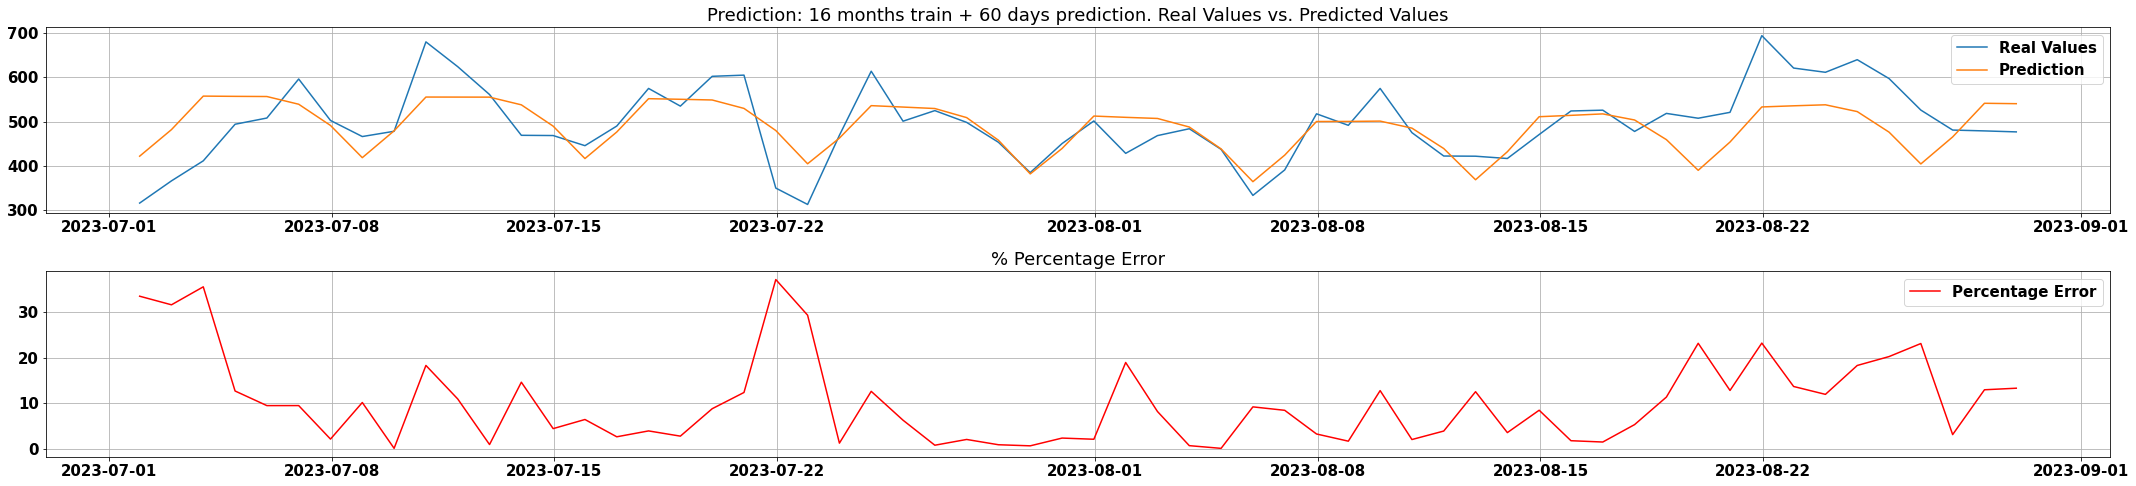

%error Real vs. Prophet Prediction: 10.31 


In [159]:
model = Prophet(yearly_seasonality = True, weekly_seasonality= True, daily_seasonality= True, changepoint_prior_scale = 0.1, seasonality_prior_scale = 0.01)
# Fit the model on historical data
model.fit(dataset_16m)

# making prediction:
future = model.make_future_dataframe(periods=60, freq='D')
forecast = model.predict(future)

# creating a combined dataset with all data to plot:
dataset_copy = dataset_CI[21864:]
forecast_copy = forecast[10223:]

forecast_copy.set_index('ds', inplace=True)
df_aligned = dataset_copy[dataset_copy.index.isin(forecast_copy.index)]
df_combined = df_aligned.join(forecast_copy, lsuffix='_hourly', rsuffix='_resampled')

# caclulating difference error (% abs):
df_combined['percerr_graph'] = (abs((df_combined['yhat']-df_combined['LCA+direct'])/df_combined['LCA+direct']))*100

# plotting:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 7))

ax1.plot(df_combined.index, df_combined['LCA+direct'], label='Real Values')
ax1.plot(df_combined.index, df_combined['yhat'], label='Prediction')
ax1.set_title(f"Prediction: 16 months train + 60 days prediction. Real Values vs. Predicted Values")
ax1.grid()
ax1.legend()

ax2.plot(df_combined.index, df_combined['percerr_graph'], 'red', label = 'Percentage Error')
ax2.set_title(f"% Percentage Error")
ax2.grid()
ax2.legend()

plt.rc("font", weight="bold", size=15)
plt.tight_layout()
plt.show()

print(f"%error Real vs. Prophet Prediction: {100*mean_absolute_percentage_error(df_combined['LCA+direct'], df_combined['yhat']):.2f} ")

We get the error of abs% 10.31, which is relatively good. Comparing it also with the naive last year value prediction (seasonal prediction: "the next value is the same as the last year value")

In [157]:
def seasonal_naive_pred(df):
    pred = []
    for i in range(1, len(df)):
        # timestamp of one year before the current timestamp, finding it inside the dataset:
        prev_year_timestamp = df.index[i - 1] - pd.DateOffset(years=1)
        
        if prev_year_timestamp not in df.index:
            pred.append(None)
        else:
            # Get the value from the same timestamp one year before
            pred.append(df.loc[prev_year_timestamp, 'LCA+direct'])
    
    pred = [None] + pred
    return pred

17:38:34 - cmdstanpy - INFO - Chain [1] start processing
17:38:52 - cmdstanpy - INFO - Chain [1] done processing


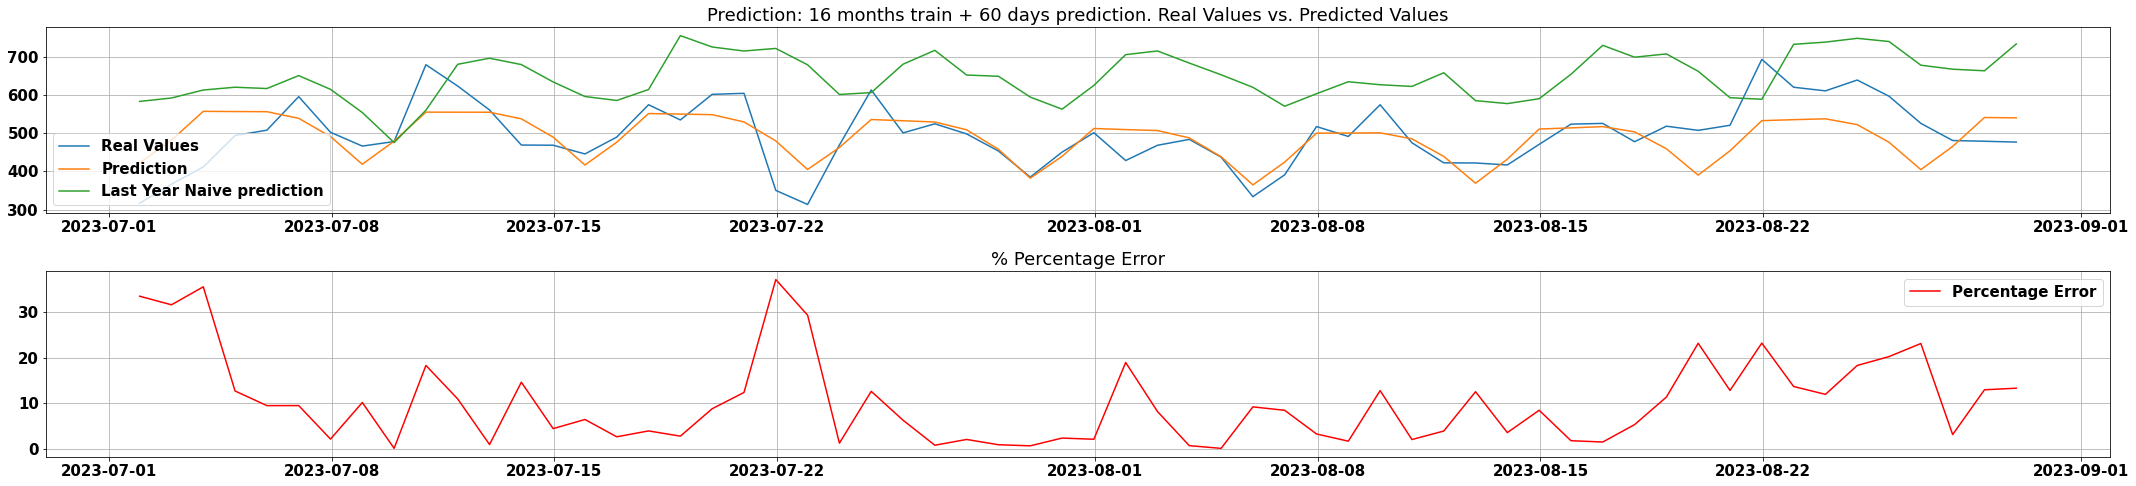

%abs error: Real Values vs. Prediction (Prophet): 10.31%
%abs error: Real Values vs. Seasonal Naive prediction 34.99%


In [158]:
model = Prophet(yearly_seasonality = True, weekly_seasonality=True, daily_seasonality=True, changepoint_prior_scale = 0.1, seasonality_prior_scale = 0.01)
# Fit the model on historical data
model.fit(dataset_16m)

future = model.make_future_dataframe(periods=60, freq='D')
forecast = model.predict(future)

dataset_CI['lastyrpred_naive'] = seasonal_naive_pred(dataset_CI)

dataset_copy = dataset_CI[21864:]
forecast_copy = forecast[10223:]

forecast_copy.set_index('ds', inplace=True)
df_aligned = dataset_copy[dataset_copy.index.isin(forecast_copy.index)]
df_combined = df_aligned.join(forecast_copy, lsuffix='_hourly', rsuffix='_resampled')

df_combined['percerr_graph'] = (abs((df_combined['yhat']-df_combined['LCA+direct'])/df_combined['LCA+direct']))*100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 7))

ax1.plot(df_combined.index, df_combined['LCA+direct'], label='Real Values')
ax1.plot(df_combined.index, df_combined['yhat'], label='Prediction')
ax1.plot(df_combined.index, df_combined['lastyrpred_naive'], label='Last Year Naive prediction')
ax1.set_title(f"Prediction: 16 months train + 60 days prediction. Real Values vs. Predicted Values")
ax1.grid()
ax1.legend()

ax2.plot(df_combined.index, df_combined['percerr_graph'], 'red', label = 'Percentage Error')
ax2.set_title(f"% Percentage Error")
ax2.grid()
ax2.legend()

plt.rc("font", weight="bold", size=15)
plt.tight_layout()
plt.show()

print(f"%abs error: Real Values vs. Prediction (Prophet): {100*mean_absolute_percentage_error(df_combined['LCA+direct'], df_combined['yhat']):.2f}%")
print(f"%abs error: Real Values vs. Seasonal Naive prediction {100*mean_absolute_percentage_error(df_combined['LCA+direct'], df_combined['lastyrpred_naive']):.2f}%")

As a result, it can be seen that better prediction is achieved compared to seasonal prediction based on last year value